# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 2.3: Testing and Benchmarking

### 2.3.1 Statistical Significance

When we want to test the results of an experiment, a normal pattern is to setup a Control and treatment group. The terminology comes from medical science, but applies to any field. The Control group is "do the task as you have previously done", or "keep everything normal". The Treatment group is "apply my idea to this group". We then evaluate the different in the two groups to determine if there is a difference or not - normally referred to as a *significant* difference, but we will come back to that term.

Suppose we have a new trading algorithm (we'll call NEW) we want to test. The current one works (named OLD) well enough, but initial testing of NEW indicates some good results. Given the random nature of the stock market, and randomness inherent in both the NEW and OLD algorithms, we can't just run them once and compare the results. In statistics, we always want to ask "Isn't there some probability that this difference happened by chance?". Statistics helps us protect against making decisions based on (un)lucky data sampling that happens.

We create 30 iterations of both NEW and OLD, and backtest on the last 5 years of trading data. We get the following profits:

In [3]:
%run setup.ipy

In [9]:
NEW = np.array([1.05174941, 1.06930758, 1.11729439, 1.12624468, 1.60443569,
       1.16272344, 1.47328065, 1.05485681, 0.74028953, 1.21066169,
       1.13720454, 1.70111553, 1.22645839, 1.26188635, 1.30603338,
       2.10036382, 1.68648174, 1.27467569, 0.37090243, 1.17720112,
       1.25108935, 1.21632526, 1.58731637, 1.08608151, 2.08776142,
       0.63474195, 0.70729046, 0.6496959 , 1.61753557, 1.0645431 ])

In [10]:
OLD = np.array([0.9847197 , 1.27252081, 0.77785125, 1.53240267, 0.97049964,
       1.09014078, 0.92529125, 0.93391001, 1.06337962, 1.04707554,
       1.04699074, 1.24765968, 0.97622673, 1.21298906, 1.14389947,
       1.08432808, 1.24983952, 0.98100972, 1.34957539, 1.1513302 ,
       1.63546461, 0.69778236, 1.46165873, 1.09680951, 1.18708603,
       1.04704617, 1.24966216, 0.90329866, 1.41676504, 1.59918173])

In [4]:
NEW.mean(), OLD.mean()

(1.2251849250000002, 1.1445464953333333)

This result is great! NEW outperforms OLD. However, isn't there a chance this occurred by chance? First, check the histograms. The mean is (usually) the best single-value summary of data, but we can learn so much, so quickly by just doing some quick visualisations:

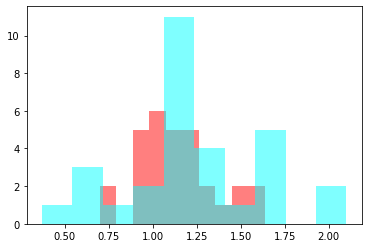

In [5]:
plt.hist(OLD, alpha=0.5, color='red')
plt.hist(NEW, alpha=0.5, color='aqua');

NEW has a greater spread, but looks to be generally a bit higher. More profit, but more risk. (Sidenote: normally we would analyse the variance more here, but we are focusing on testing this improvement in this module.)

We *could* fit distribution models to the data, determine if the results are normal, fit normal distributions, compare the results using a two-side t-test. This will work for this data, but may not work for other data in the real world.

A method that is as rigourous\*, but more broadly applicable is simulation. You did a Monte Carlo simulation in a previous Extended Exercise - here we will cover a simple pattern that you can use, even if you don't have a simulation environment setup.

\* It is just as rigourous, only if you have sufficient data. The data requirement for simulations is higher than a t-test.

### Re-randomised subsets

Our data is currently split into two groups - NEW and OLD. Comparing the difference of means, we get this value: 

In [6]:
experiment_difference_in_means = NEW.mean() - OLD.mean()
experiment_difference_in_means

0.0806384296666669

We want to know - "is this result impressive?". More specifically, "what is the probability that this happened by chance?".

In trading, results can be volatile. This means that we can observe differences this large, by just choosing a different subset of stocks, or a different random starting point in our algorithm.

To evaluate this, we take *all* the data we have collected so far, and create a new, randomly selected split. We then compute the difference of means. We do this many times, and then see how many resulting in a difference of means at least as great:

In [4]:
np.random.shuffle?

In [5]:
np.random.seed?

In [6]:
np.random.seed(42)

In [7]:
def create_random_subsets(all_data):
    """Randomly splits all_data into two groups"""
    # Note this is an in-place operation - all_data is changed by this call!
    # If you didn't want this to happen, create a copy of all_data first. We dont' care here though
    np.random.shuffle(all_data)
    midpoint = int(len(all_data) / 2)
    return all_data[:midpoint], all_data[midpoint:]

In [12]:
np.hstack?

In [11]:
all_data = np.hstack([NEW, OLD])
all_data.shape

(60,)

In [13]:
sample1, sample2 = create_random_subsets(all_data)

In [14]:
sample2

array([0.70729046, 1.68648174, 2.08776142, 1.04704617, 1.70111553,
       0.77785125, 1.09680951, 1.24765968, 0.93391001, 1.0645431 ,
       1.14389947, 1.06930758, 1.21632526, 1.11729439, 0.98100972,
       1.04707554, 1.09014078, 1.08608151, 1.1513302 , 1.13720454,
       1.58731637, 0.37090243, 1.59918173, 1.25108935, 1.05485681,
       0.97622673, 1.30603338, 1.61753557, 0.69778236, 1.06337962])

In [15]:
sample1.mean() - sample2.mean()

0.04210193966666664

Most of the time, when you run this, you'll get a value near 0. This is because:

* We assume that NEW was generated by one mechanism, just randomly within that mechanism
* We assume that OLD was generated by one mechanism (different to NEW)
* Our random sample will have about the same number of NEW and OLD values

This all averages out, and we expect each sample's mean to be the mean of the whole dataset. Given two samples like this, the difference will be about zero. 

In [16]:
def sample_and_compare(all_data):
    """Run a single iteration of (1) split randomly, and (2) compute difference of means"""
    # Same code as above, just in a function
    sample1, sample2 = create_random_subsets(all_data)
    return sample1.mean() - sample2.mean()

In [17]:
# Do that 1000 times
differences = np.array([sample_and_compare(all_data) for _ in range(1000)])

# Sidenote: the _ after the word for is a valid variable name.
# We use _ as a variable name to indicate to future readers of the program that:
# "This is a variable, but I don't really care about it, its value doesn't matter".
# Often you'll see i here instead - that's perfectly fine too

In [18]:
differences.mean()  # Expected to be about zero. Your result may vary slightly
# The reason behind this zero estimate is that each data point, ether being from NEW or OLD,
# is always counted once either positively or negatively (with the same probability) in 
# the sample_and_compare(all_data) iteration

-0.00028032517400000987

(array([  2.,  27.,  66., 148., 201., 236., 171., 102.,  33.,  14.]),
 array([-0.26254333, -0.21219628, -0.16184923, -0.11150218, -0.06115513,
        -0.01080808,  0.03953897,  0.08988602,  0.14023307,  0.19058012,
         0.24092717]),
 <BarContainer object of 10 artists>)

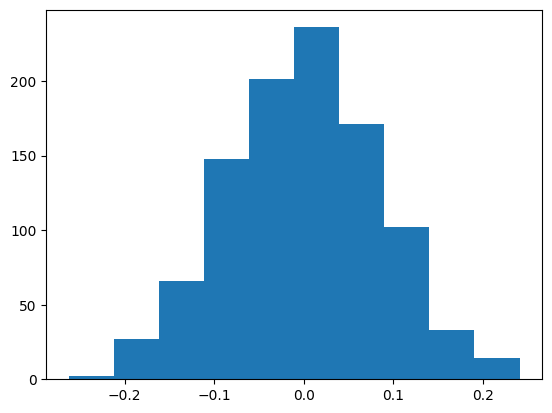

In [19]:
plt.hist(differences)

Just eyeballing it, you can see *about* 1/3 of the values are above 0.08. We normally test the absolute value - i.e. how likely is it we get an absolute value above the observed one. This gives a clearer picture if we are unsure of which group (control - OLD, or treatment - NEW) is better.

Let's find out exactly:

In [18]:
(np.abs(differences) > experiment_difference_in_means).mean()

0.356

Here we can see that 36% of the values in our simulation are above the observed difference in the data. Therefore we can say that:

    There is a 36% chance that the observed difference between NEW and OLD occurred by chance.
    
A drawback of using this method to determine significance is the necessity of having the same number of data points in OLD and NEW, one can use some random sampling method to adress this problem such as bootstrapping (https://en.wikipedia.org/wiki/Bootstrapping_(statistics).

### Is that difference "significant"?

A key term you'll hear, and use, when presenting results of statistical tests is whether the result is significant or not. This is a loaded term in statistics, so it is important to distinguish between these two variants:

* **Statistical significance** occurs when the Null Hypothesis is unlikely to have occurred by chance, given a significance threshold (usually 0.05). That is, if there is a less than 5% chance of the Null hypothesis having occurred by chance, we claim this result is **statistically significant**.
* A **significant** result is one that causes an improvement that is worth the investment. That is, if a treatment causes an improvement, and we want to use the treatment now, that result is significant.


In the above result, we can say that the result of our experiment is **not statistically significant**. That is because there is a 36% chance that the difference in the profit between NEW and OLD occurred purely by chance.

However, when we compare the average profit, NEW has a profit 8 percentage points higher than OLD. If we are happy with the increased risk, then we would say that this increase in profits is **significant** and that we should switch to NEW for our trading strategy.

More often than not, a significant result that is not statistically significant is just a case of not enough data. If I generate the data again, using the same mechanism as I did for the data at the start of this module, but with many, many more data points, we'll get a result that is both significant and statistically significant:

In [20]:
# NEW: mu=0.17, std = 0.35
# OLD: mu = 0.12, std=0.25
N_SAMPLES = 100000
NEW_large = 1 + np.random.randn(N_SAMPLES) * 0.35 + 0.17
OLD_large = 1 + np.random.randn(N_SAMPLES) * 0.25 + 0.12

In [21]:
experiment_difference_in_means_large = NEW_large.mean() - OLD_large.mean()

In [22]:
experiment_difference_in_means_large  # Not as large as before, but 5 percentage points is still good

0.04871454033710165

In [23]:
# Rerun our simulations. This takes quite a bit longer than before.
all_data_large = np.hstack([NEW_large, OLD_large])
differences_large = np.array([sample_and_compare(all_data_large) for _ in range(10000)])

In [24]:
(np.abs(differences_large) > experiment_difference_in_means_large).mean()  # Percentage

0.0

In [25]:
(np.abs(differences_large) > experiment_difference_in_means_large).sum()  # Absolute value

0

In other words, *none* of the observed difference in means in our randomised subsets were as high as our experimental difference. (Your results may vary, but you'll get a very low number here, and a percentage nearly 0).

This result is both **significant**, in that we expect more money now from the new strategy, and **statistically significant** because it is unlikely this result occurred by chance. The data didn't change from above - we just used it in a more structured format.

Note that there are some cases where it isn't just a data issue. In these cases the variance is so large, or the data has a pattern that causes the above to be inconclusive from a statistical perspective. However be mindful of the difference.

### A common misconception with p

Most people misinterpret what a p value means. Let's say we have our original result of NEW and OLD (the one with 30 samples each). A common misinterpretation of the "high" p value is to say there is "no difference" between the two samples. If we are measuring a correlation and get a high p value, one might say there is "no correlation", even if we do get a linear correlation value, just one that has a high p value. In these cases, one would be wrong to say this.

Our observed difference was 0.08 - not "no difference". There is just a 33.6% chance that randomly doing the experiment would yield the same, or higher, result.

[This article in Nature](https://www.nature.com/articles/d41586-019-00857-9) gives an example of two experiments on the same treatment - an anti-inflammatory drug. Both experiments tested if there was a correlation between using the drug and new-onset atrial fibrillation. One paper concludes the drug is associated with the condition. One paper concludes that it is not associated with the condition. Which is correct? 

In the "no association" experiment, the 95% confidence interval spanned between a decrease of 3% of the risk of the condition to a 48% increase in risk. However, due to the statistical test, the confidence interval included 0, indicating that there is greater than 5% chance that the increased risk observed was due to chance. The Nature article calculated the p value as 0.091.

The "association" experiment found the 95% confidence interval between a 9% increased risk to a 33% increased risk. As zero is not in the confidence interval, they concluded that there was an association.

Here is the key finding - both experiments had a mean increased risk of 20%. The second experiment just had more data. An average increased risk of 20% for atrial fibrillation is **significant**. Data sample size indicated that it was not **statistically significant** in the first "no association" experiment.

There are calls from lots of scientists to stop using the term "statistically significant". Further, studies have shown about *half* of papers wrongly interpret their p values. The issue isn't so much with the tests themselves, it is the interpretation of the tests that is the problem, and the common "intuition" that "not statistically significant" means "no difference" or "not important".

To make matters worse, most people will use 0.05 as their threshold without any consideration for what this means, and whether such a value makes sense. 

The solution is to be clear with what your test results present, and how they could be used in decision making. Do not use shortcuts like "statistically significant", when key decisions (like your p value threshold of 0.05 or your "95%" confidence interval) are arbitrarily defined. 


#### Exercise

1. Read the linked Nature article on problems with P values: https://www.nature.com/articles/d41586-019-00857-9
2. Write a summary (about two or three sentences) explaining the results of the 30-sample NEW versus OLD result. Be clear on terminology. You can compute confidence intervals as well to present these findings, but again, be clear about what that means.

If you are doing this course with a group or partner, get them to check your explanation, and discuss whether you would move to NEW based on the summary you presented.

Note: There is no solution to this exercise